In [1]:
import itertools
import gc
from bib import *
import numpy as np
import pandas as pd
from  tqdm import tqdm_notebook
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV 

In [20]:
xtrains,ytrains,xvals,yvals,xtest,ytest=split(('CHL 1','THERM 1','SSH','SR','WS'),
                                               ['CHL '+ str(i) for i in range(2,19)])
ytrains,yvals,ytest=applyToy(lambda x:np.log(x)/np.log(10),ytrains,yvals,ytest)

In [3]:
def validate(params,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    first= True
    for xt,yt,xv,yv in tqdm_notebook(zip(xtrains,ytrains,xvals,yvals),total=len(xtrains),leave=False):
        

    
        model=xgb.XGBRegressor(
               colsample_bytree=params['colsample_bytree'],
               gamma=params['gamma'],
               min_child_weight=params['min_child_weight'],
               learning_rate=params['learning_rate'],
               max_depth=params['max_depth'],
               n_estimators=params['n_estimators'],
               reg_alpha=params['reg_alpha'],
               reg_lambda=params['reg_lambda'],
               subsample=params['subsample']  ,
                objective='reg:linear')
        multioutputregressor = MultiOutputRegressor(model,n_jobs=-1).fit(xt.values,yt.values)
        yp=multioutputregressor.predict(xv)
        #check error in original space
            
        fold_evaluation.append(evaluate(yp,yv))
        if first:
            print(evaluate(yp,yv))
            first=False
        
    return np.mean(fold_evaluation),np.std(fold_evaluation )


In [4]:
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1,0.3],
   'min_child_weight':[1.5,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[100,1000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]  
}
i=0
while True:
    params={}
    for key in parameters_for_testing:
        params[key]=parameters_for_testing[key][i%len(parameters_for_testing[key])]
#         print(i%len(parameters_for_testing[key]))
        i+=13
    print(params)
    error,std=validate(params,xtrains,ytrains,xvals,yvals)
    print('\t error: %.5f +- %.5f' % (error,std))

{'colsample_bytree': 0.4, 'gamma': 0.03, 'min_child_weight': 10, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.6}


0.06046801773440248
	 error: 0.06442 +- 0.01607
{'colsample_bytree': 0.4, 'gamma': 0.1, 'min_child_weight': 10, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 1e-05, 'reg_lambda': 0.01, 'subsample': 0.95}


0.060397500301346274


KeyboardInterrupt: 

{'learning_rate': 0.07, 'min_child_weight': 6, 'n_estimators': 1000, 'reg_alpha': 1e-05, 'subsample': 0.95, 'reg_lambda': 0.45, 'colsample_bytree': 0.6, 'gamma': 0.03, 'max_depth': 5}

{'learning_rate': 0.07, 'min_child_weight': 10, 'n_estimators': 1000, 'reg_alpha': 1e-05, 'subsample': 0.95, 'reg_lambda': 0.01, 'colsample_bytree': 0.8, 'gamma': 0.03, 'max_depth': 5}

In [6]:
params = {'learning_rate': 0.07, 'min_child_weight': 10, 'n_estimators': 1000, 'reg_alpha': 1e-05, 
          'subsample': 0.95, 'reg_lambda': 0.01, 'colsample_bytree': 0.8, 'gamma': 0.03, 'max_depth': 5}

error,std=validate(params,xtrains,ytrains,xvals,yvals)
print('\t error: %.5f +- %.5f' % (error,std))

0.054901070610571194
	 error: 0.06197 +- 0.01647


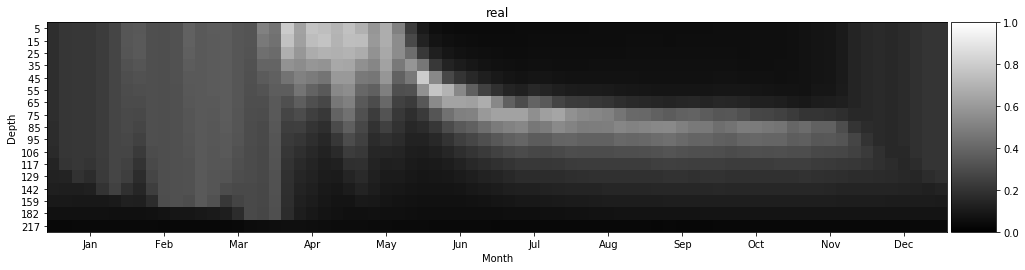

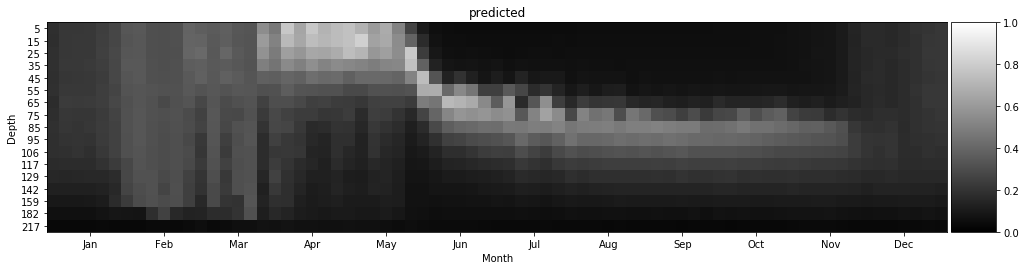

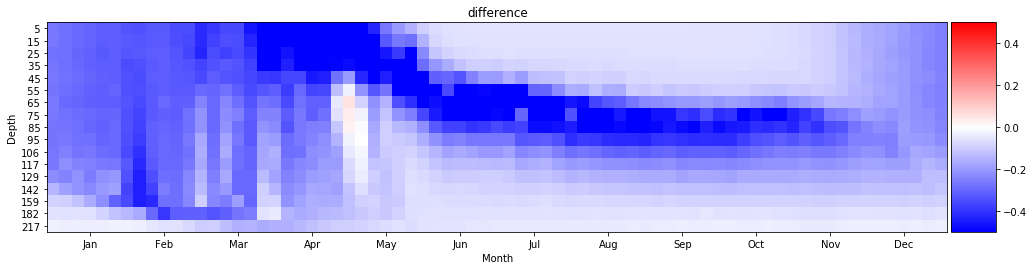

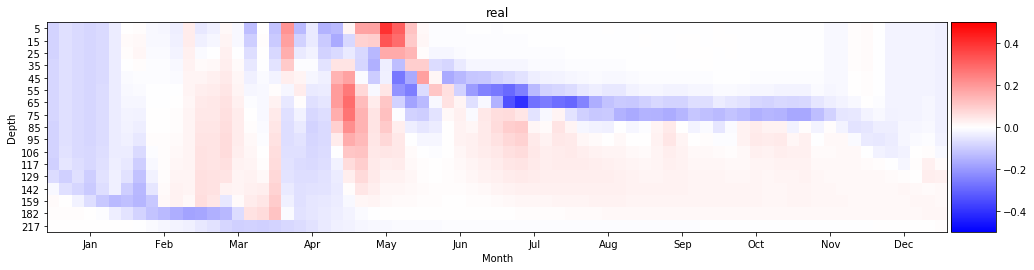

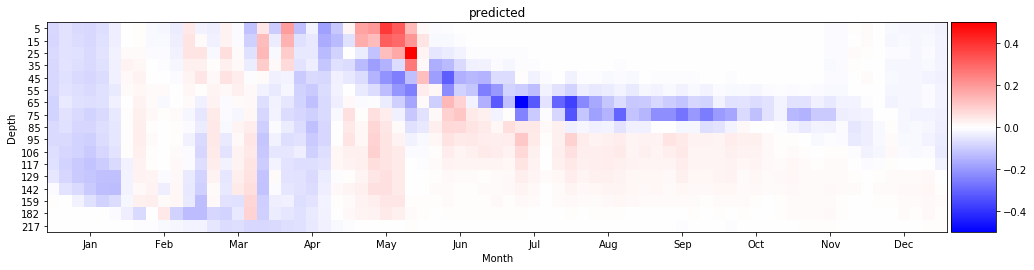

In [24]:
model = xgb.XGBRegressor(
               colsample_bytree=params['colsample_bytree'],
               gamma=params['gamma'],
               min_child_weight=params['min_child_weight'],
               learning_rate=params['learning_rate'],
               max_depth=params['max_depth'],
               n_estimators=params['n_estimators'],
               reg_alpha=params['reg_alpha'],
               reg_lambda=params['reg_lambda'],
               subsample=params['subsample']  ,
                objective='reg:linear')
multioutputregressor = MultiOutputRegressor(model,n_jobs=-1).fit(xtrains[0].values, ytrains[0].values)
yp=multioutputregressor.predict(xtest)

#yp = model.predict(xtest)
plotYear(np.exp(ytest*np.log(10)),title='real')
plotYear(np.exp(yp*np.log(10)),title='predicted')
climato(np.exp(ytest*np.log(10)).values-np.exp(yp*np.log(10)), title='difference')
climato(np.exp(ytest*np.log(10)).values, title='real')
climato(np.exp(yp*np.log(10)), title='predicted')